# Table of Contents

# Libraries

In [1]:
#import packages for analysis
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.font_manager as fm
from matplotlib.lines import Line2D
from numpy import log10
import numpy as np
import matplotlib.patches as mpatches
import scipy.stats
from scipy.optimize import curve_fit
from sklearn.metrics import r2_score 
import numpy as np

from gnat import misc_utils
from gnat import error_calculator
from gnat import rarefaction
from gnat import gtf_tools
from gnat import kegg_tools

# Data Loading

In [2]:
# load data and analysis metadata
data = pd.read_csv('data/counts_tables/dpl_tpm_counts_kallisto.csv')
data.rename(columns={data.columns[0]: "sample-id" }, inplace = True)
metadata = pd.read_csv('data/mtstp_analysis_metadata.tsv', sep="\t")

#since this analysis will onyl deal with uninfected individuals, I'll filter out all infected samples
uninfected_samples = list(metadata.loc[metadata['infection-status'] != 'infected']['sample-id'])
uninfected_data = data[data['sample-id'].isin(uninfected_samples)]
uninfected_data.set_index("sample-id", inplace = True)

In [5]:
metadata

,sample-id,plant,infection-status,developmental-stage,lineage
0,mtstp3ci10,curassavica,infected,third-instar,EJ
1,mtstp3ci11,curassavica,infected,third-instar,EJ
2,mtstp3ci12,curassavica,infected,third-instar,AT
3,mtstp3ci13,curassavica,infected,third-instar,AT
4,mtstp3ci9,curassavica,infected,third-instar,EJ
...,...,...,...,...,...
91,mtstpLiu129,incarnata,uninfected,late-pupa,EJ
92,mtstpLiu130,incarnata,uninfected,late-pupa,EJ
93,mtstpLiu131,incarnata,uninfected,late-pupa,EJ
94,mtstpLiu133,incarnata,uninfected,late-pupa,AT


In [6]:
uninfected_data

,lcl|KZ248545.1_cds_OWR45966.1_1,lcl|KZ248545.1_cds_OWR42929.1_2,lcl|KZ248545.1_cds_OWR42930.1_3,lcl|KZ248545.1_cds_OWR42931.1_4,lcl|KZ248545.1_cds_OWR42932.1_5,lcl|KZ248545.1_cds_OWR42933.1_6,lcl|KZ248545.1_cds_OWR42934.1_7,lcl|KZ248545.1_cds_OWR42935.1_8,lcl|KZ248545.1_cds_OWR42936.1_9,lcl|KZ248545.1_cds_OWR51149.1_10,...,lcl|KZ253939.1_cds_OWR46811.1_15223,lcl|KZ253939.1_cds_OWR46812.1_15224,lcl|KZ253939.1_cds_OWR46813.1_15225,lcl|KZ253939.1_cds_OWR46814.1_15226,lcl|KZ253939.1_cds_OWR46815.1_15227,lcl|KZ253939.1_cds_OWR48030.1_15228,lcl|KZ253939.1_cds_OWR48031.1_15229,lcl|KZ253939.1_cds_OWR48032.1_15230,lcl|KZ253939.1_cds_OWR48033.1_15231,lcl|KZ253939.1_cds_OWR55584.1_15232
sample-id,,,,,,,,,,,,,,,,,,,,,
mtstp5iu98,40.307900,56.571700,1108.7200,161.260000,3.714120,1.121030,0.000000,4.427440,80.614100,0.571328,...,7.63375,8.38529,5.12428,1.773930,0.788076,0.011144,21.51140,25.0025,0.000000,0.857986
mtstp3cu2,117.197000,158.977000,473.1770,50.214300,51.896000,1.055150,0.024980,3.666070,47.019600,1.520990,...,15.86870,12.53940,48.76550,3.593860,1.226600,0.291278,29.57810,105.5880,0.000000,8.049470
mtstp5cu17,53.580300,72.488100,847.3960,143.629000,6.129130,0.000000,0.000000,1.789000,68.445200,1.173910,...,8.82507,8.81382,4.24864,0.897578,0.765841,0.000000,31.69200,76.7036,0.000000,2.985790
mtstpLiu130,0.036026,0.000000,750.5200,3.536750,3.418260,0.629009,0.000000,0.529960,1.137820,11.142000,...,13.34150,5.86868,133.43200,1.111620,1.160870,0.006044,55.27390,130.0230,0.000000,0.239330
mtstpLiu133,0.025680,0.091779,439.9790,8.929790,2.229130,2.650270,1.432950,2.357130,0.270234,8.235870,...,11.09360,5.79064,146.81100,1.351020,1.207460,0.025850,38.63890,70.4854,0.000000,0.000000
mtstpEcu38,0.000000,0.011409,205.2790,0.678483,4.695950,0.953417,0.020652,0.044239,0.000000,6.483220,...,9.24495,12.27980,355.74000,3.540060,1.861930,0.008570,44.80340,223.3030,0.717028,2.056850
mtstpAiu148,20.759100,32.852500,879.6510,6.046150,6.695500,0.369350,0.351016,5.922370,4.350970,66.263500,...,34.54550,4.44715,39.52500,1.589870,1.345300,0.131708,23.62360,65.2631,0.000000,0.374311
mtstp5iu100,32.551700,40.219300,1100.9300,173.425000,5.561670,1.156950,0.000000,2.484970,86.955500,1.052060,...,9.33069,8.27777,9.11512,1.463130,0.947899,0.000000,26.54300,54.4123,0.000000,0.933983
mtstpLiu131,1.578640,1.649300,1298.7200,9.646060,0.334944,0.417812,0.834579,7.058230,2.366580,19.060900,...,21.34560,2.39756,138.19300,0.970659,0.904959,0.000000,16.73580,79.4092,0.000000,0.106698


# Clustering across developmental stages

In [7]:
#I'll use R to get distance matricies because that's easier for me
#we'll focuse on Euclidian but get Manhattan for later if we want
!./scripts/get_distance_matricies.R

Warning message:
In dist(data, method = "euclidian") : NAs introduced by coercion
Warning message:
In dist(data, method = "manhattan") : NAs introduced by coercion


/home/gabe/anaconda3/lib/python3.9/site-packages/seaborn/_core.py:1225: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/home/gabe/anaconda3/lib/python3.9/site-packages/seaborn/_core.py:1225: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/home/gabe/anaconda3/lib/python3.9/site-packages/seaborn/_core.py:1225: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/home/gabe/anaconda3/lib/python3.9/site-packages/seaborn/_core.py:1225: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.

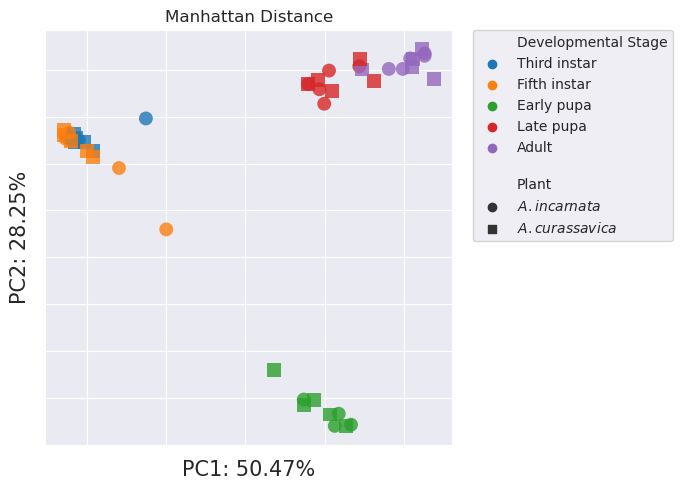

In [9]:
manhattan_distance_matrix = pd.read_csv('data/distance_matricies/manhattan.csv', index_col=0)
#remove infected samples
for sample in list(manhattan_distance_matrix):
    if sample[7] == 'i':
        manhattan_distance_matrix.drop(labels=sample, axis=0, inplace=True)
        manhattan_distance_matrix.drop(labels=sample, axis=1, inplace=True)

#and now to load and plot the data
manhattan_pca_data = pd.read_csv('data/manhattan_uninfected_pca.csv', index_col=0)[["PC1", "PC2"]]
#add metadata data
stage = []
plant = []

for sample in list(manhattan_pca_data.index):
    if sample[5] == '3':
        stage.append('third-instar')
    elif sample[5] == '5':
        stage.append('fifth-instar')
    elif sample[5] == 'E':
        stage.append('early-pupa')
    elif sample[5] == 'L':
        stage.append('late-pupa')
    elif sample[5] == 'A':
        stage.append('adult')

    if sample[6] == 'i':
        plant.append('A. incarnata')
    elif sample[6] == 'c':
        plant.append('A. curassavica')
        
manhattan_pca_data['developmental-stage'] = stage
manhattan_pca_data['plant'] = plant

#and now to plot
sns.set_style('darkgrid')

fig, ax1 = plt.subplots(1, 1, figsize=(7, 5))
hue_order = ['third-instar', 'fifth-instar', 'early-pupa', 'late-pupa', 'adult']
manhattan_pca_plot = sns.scatterplot(data=manhattan_pca_data, x='PC1', y='PC2', ax=ax1, hue='developmental-stage', 
                style='plant', hue_order = hue_order,
                s=100, alpha=0.8, edgecolor = 'none', markers=['o', 's'])

ax1.set_xlabel('PC1: 50.47%', size=15)
ax1.set_ylabel('PC2: 28.25%', size=15)
ax1.set_xticklabels([])
ax1.set_yticklabels([])

handles, previous_labels = ax1.get_legend_handles_labels()
ax1.legend(handles=handles, 
           labels=['Developmental Stage', 'Third instar', 'Fifth instar', 'Early pupa', 'Late pupa', 'Adult', '\nPlant', '$A. incarnata$', '$A. curassavica$'],
          bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0)

ax1.set_title("Manhattan Distance")
plt.tight_layout()
plt.savefig('../figures/primary/manhattan_pca.pdf')

/tmp/ipykernel_154450/347136131.py:60: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  matrix['transition'] = pd.Categorical(matrix['transition'], categories = transitions)
/home/gabe/anaconda3/lib/python3.9/site-packages/seaborn/_core.py:1225: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/home/gabe/anaconda3/lib/python3.9/site-packages/seaborn/categorical.py:253: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  grouped_val

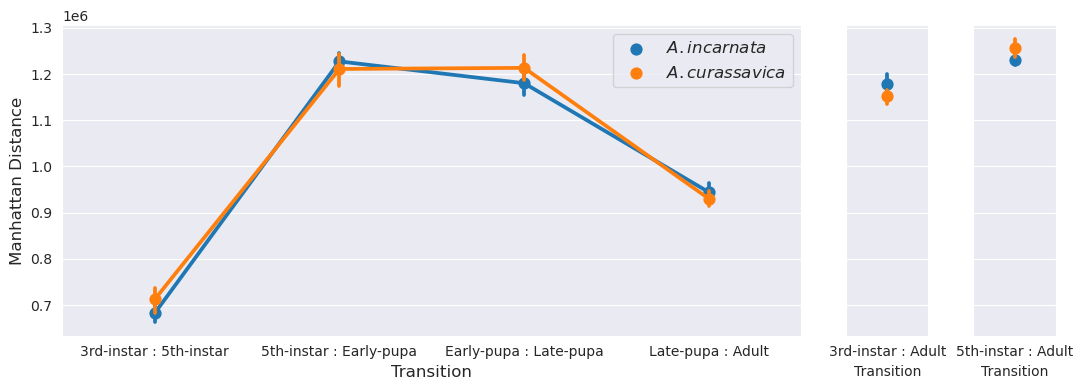

In [13]:
#and a function to get this info parsed to the form I want
def parse_distance_data(distance_matrix):
    #redefine dataframe to perserve origional dataframe
    matrix = distance_matrix
    
    #add plant and comparison metadata
    transition = []
    plant = []
    
    comparison1_values = list(matrix["comp1"])
    comparison2_values = list(matrix["comp2"])
    
    for i in range(len(comparison1_values)):
        sample1_id = comparison1_values[i]
        sample2_id = comparison2_values[i]
        
        if sample1_id[6] == sample2_id[6]:
            #define comparisons
            if sample1_id[5] == '3' and sample2_id[5] == '5' or sample1_id[5] == '5' and sample2_id[5] == '3':
                transition.append('3rd-instar : 5th-instar')
                if sample1_id[6] == 'c':
                    plant.append('A. curassavica')
                elif sample1_id[6] == 'i':
                    plant.append('A. incarnata')
            elif sample1_id[5] == '5' and sample2_id[5] == 'E' or sample1_id[5] == 'E' and sample2_id[5] == '5':
                transition.append('5th-instar : Early-pupa')
                if sample1_id[6] == 'c':
                    plant.append('A. curassavica')
                elif sample1_id[6] == 'i':
                    plant.append('A. incarnata')
            elif sample1_id[5] == 'E' and sample2_id[5] == 'L' or sample1_id[5] == 'L' and sample2_id[5] == 'E':
                transition.append('Early-pupa : Late-pupa')
                if sample1_id[6] == 'c':
                    plant.append('A. curassavica')
                elif sample1_id[6] == 'i':
                    plant.append('A. incarnata')
            elif sample1_id[5] == 'L' and sample2_id[5] == 'A' or sample1_id[5] == 'A' and sample2_id[5] == 'L':
                transition.append('Late-pupa : Adult')
                if sample1_id[6] == 'c':
                    plant.append('A. curassavica')
                elif sample1_id[6] == 'i':
                    plant.append('A. incarnata')
            else:
                transition.append('NA')
                plant.append('NA')         
        else:
            transition.append('NA')
            plant.append('NA')

    
    #add comparisons to dataframe
    matrix['transition'] = transition
    matrix['plant'] = plant
    
    #remove na values
    matrix = matrix.loc[matrix['transition'] != 'NA']
    
    #sort data by transition order
    transitions = ['3rd-instar : 5th-instar', '5th-instar : Early-pupa', 'Early-pupa : Late-pupa', 'Late-pupa : Adult']
    matrix['transition'] = pd.Categorical(matrix['transition'], categories = transitions)
    matrix = matrix.sort_values(by='transition')
    
    return matrix

#now I want to add some specific comparisons
#and a function to get this info parsed to the form I want
def parse_distance_data_specific(distance_matrix):
    #redefine dataframe to perserve origional dataframe
    matrix = distance_matrix
    
    #add plant and comparison metadata
    transition = []
    plant = []
    
    comparison1_values = list(matrix["comp1"])
    comparison2_values = list(matrix["comp2"])
    
    for i in range(len(comparison1_values)):
        sample1_id = comparison1_values[i]
        sample2_id = comparison2_values[i]
        
        if sample1_id[6] == sample2_id[6]:
            #define comparisons
            if sample1_id[5] == '3' and sample2_id[5] == 'A' or sample1_id[5] == 'A' and sample2_id[5] == '3':
                transition.append('3rd-instar : Adult')
                if sample1_id[6] == 'c':
                    plant.append('A. curassavica')
                elif sample1_id[6] == 'i':
                    plant.append('A. incarnata')
                    
            elif sample1_id[5] == '5' and sample2_id[5] == 'A' or sample1_id[5] == 'A' and sample2_id[5] == '5':
                transition.append('5th-instar : Adult')
                if sample1_id[6] == 'c':
                    plant.append('A. curassavica')
                elif sample1_id[6] == 'i':
                    plant.append('A. incarnata')
            else:
                transition.append('NA')
                plant.append('NA')         
        else:
            transition.append('NA')
            plant.append('NA')

    
    #add comparisons to dataframe
    matrix['transition'] = transition
    matrix['plant'] = plant
    
    #remove na values
    matrix = matrix.loc[matrix['transition'] != 'NA']
    
    return matrix



#convert data to long format
manhattan_matrix_long = manhattan_distance_matrix.stack().reset_index()
manhattan_matrix_long.columns = ['comp1', 'comp2', 'manhattan_distance']
manhattan_matrix_long = manhattan_matrix_long[manhattan_matrix_long['comp1'] != manhattan_matrix_long['comp2']]
#parse comparisons
manhattan_data = parse_distance_data(manhattan_matrix_long)

manhattan_data_l_a = parse_distance_data_specific(manhattan_matrix_long)

sns.set_style("darkgrid")

fig, ax = plt.subplots(1, 3, figsize=(11, 4), gridspec_kw={'width_ratios': [9, 1, 1]}, sharey=True)

sns.pointplot(data=manhattan_data, y="manhattan_distance", x="transition", hue="plant", ax=ax[0])
ax1_legend=ax[0].legend(prop=fm.FontProperties(size=12))
ax1_legend.get_texts()[1].set_text('$A. curassavica$')
ax1_legend.get_texts()[0].set_text('$A. incarnata$')
ax[0].set_ylabel('Manhattan Distance', size=12)
ax[0].set_xlabel('Transition', size=12)

sns.pointplot(data=manhattan_data_l_a.loc[manhattan_data_l_a['transition'] == '3rd-instar : Adult'], y="manhattan_distance", x="transition", hue="plant", ax=ax[1], legend=False)
ax[1].set_ylabel('')
ax[1].set_xlabel('Transition')
ax[1].get_legend().remove()

sns.pointplot(data=manhattan_data_l_a.loc[manhattan_data_l_a['transition'] == '5th-instar : Adult'], y="manhattan_distance", x="transition", hue="plant", ax=ax[2], legend=False)
ax[2].set_ylabel('')
ax[2].set_xlabel('Transition')
ax[2].get_legend().remove()

plt.tight_layout()
plt.subplots_adjust(wspace=0.15)
plt.savefig('../figures/primary/manhattan_distance_pointplot.pdf')

# Differential gene expression between developmental stages

In [14]:
#as usual, I like to do my stats in R. Plus I like the edgeR algorithm for DEG analysis. I've read it's more conservative
!./scripts/edgeR_across_development.R

Loading required package: limma
Using classic mode.
Using classic mode.
Using classic mode.
Using classic mode.
Using classic mode.
Using classic mode.
Using classic mode.
Using classic mode.


/tmp/ipykernel_154450/1847269294.py:8: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value 'up' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.
  df.loc[(df['FDR'] < 0.01) & (df['logFC'] > 0), 'regulation'] = 'up'
/tmp/ipykernel_154450/1847269294.py:8: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value 'up' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.
  df.loc[(df['FDR'] < 0.01) & (df['logFC'] > 0), 'regulation'] = 'up'
/tmp/ipykernel_154450/1847269294.py:8: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value 'up' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.
  df.loc[(df['FDR'] < 0.01) & (df['logFC'] > 0), 'regulation'] = 'up'
/tmp/ipykernel_154450/1847269294.py:8: F

/home/gabe/anaconda3/lib/python3.9/site-packages/seaborn/_core.py:1225: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/home/gabe/anaconda3/lib/python3.9/site-packages/seaborn/_core.py:1225: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):


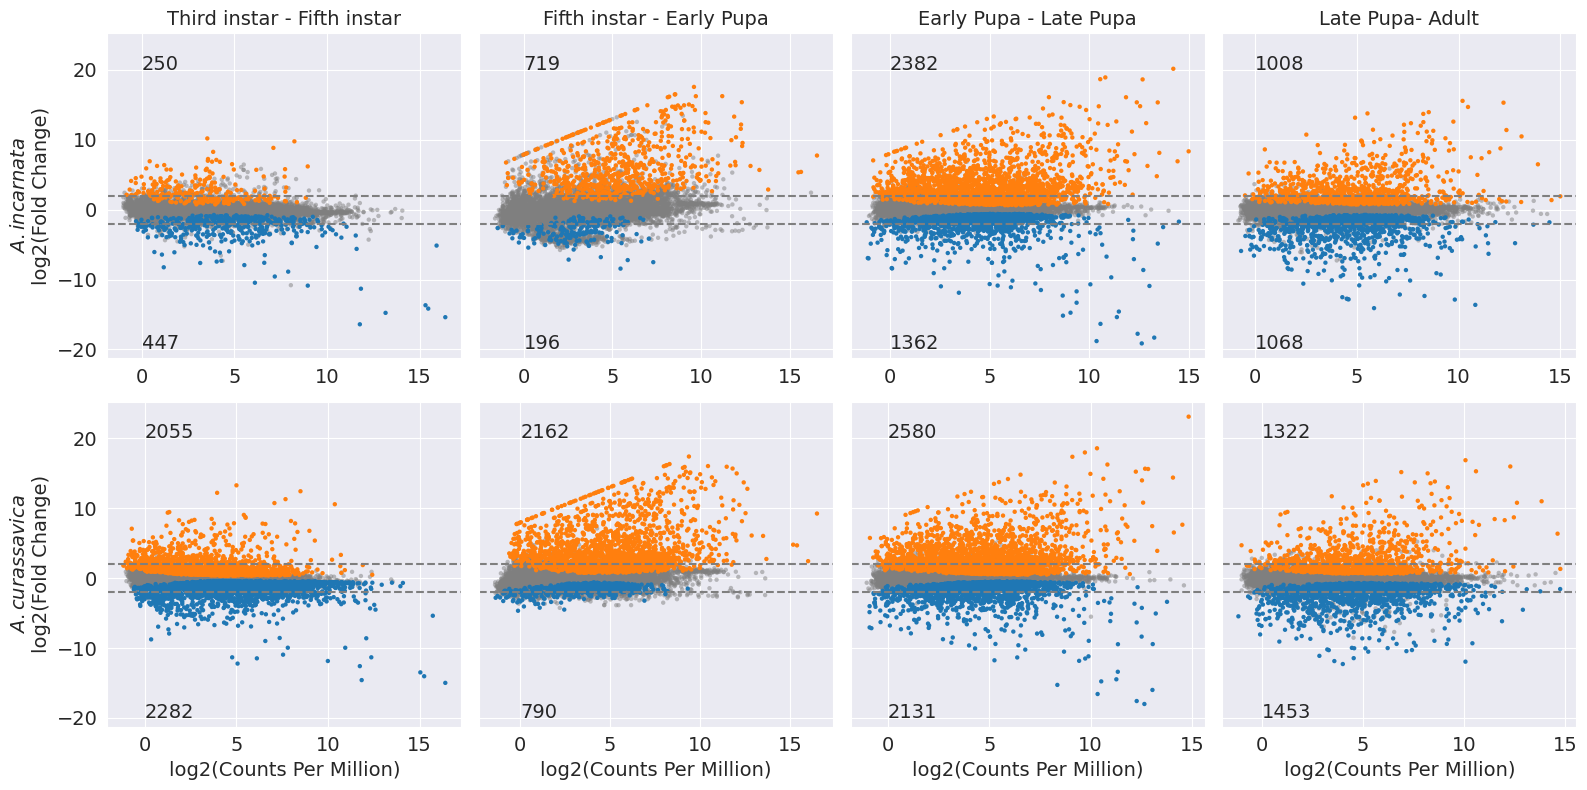

In [15]:
#Load the differential expression data that was just generated
def load_de_data(file):
    #read data
    df = pd.read_csv(file, index_col=0)
    #add column for significantly up or down
    df["regulation"] = df["FDR"]
    #if FDR is less than cutoff and logFC is greater than 0, regulation = up
    df.loc[(df['FDR'] < 0.01) & (df['logFC'] > 0), 'regulation'] = 'up'
    #if FDR is less than cutoff and logFC is less than 0, regulation = down
    df.loc[(df['FDR'] < 0.01) & (df['logFC'] < 0), 'regulation'] = 'down'
    #if FDR is greater than cutoff, regulation = NA
    df.loc[df['FDR'] > 0.01, 'regulation'] = 'NA'
    
    return df

#whoops, messed up my file names a bit. Ohh well
#3-5
third_to_fifth_inc = load_de_data('data/edgeR/across_development/third_to_fifth_inc_incarnata')
third_to_fifth_cur = load_de_data('data/edgeR/across_development/third_to_fifth_cur_curassavica')

#5-E
fifth_to_early_inc = load_de_data('data/edgeR/across_development/fifth_to_early_inc_incarnata')
fifth_to_early_cur = load_de_data('data/edgeR/across_development/fifth_to_early_cur_curassavica')

#E-L
early_to_late_inc = load_de_data('data/edgeR/across_development/early_to_late_inc_incarnata')
early_to_late_cur = load_de_data('data/edgeR/across_development/early_to_late_cur_curassavica')

#E-L
late_to_adult_inc = load_de_data('data/edgeR/across_development/late_to_adult_inc_incarnata')
late_to_adult_cur = load_de_data('data/edgeR/across_development/late_to_adult_cur_curassavica')

#get number of up and down regulated genes for each stage
third_to_fifth_inc_up_count = len(third_to_fifth_inc.loc[third_to_fifth_inc['regulation'] == 'up'])
third_to_fifth_inc_down_count = len(third_to_fifth_inc.loc[third_to_fifth_inc['regulation'] == 'down'])
third_to_fifth_cur_up_count = len(third_to_fifth_cur.loc[third_to_fifth_cur['regulation'] == 'up'])
third_to_fifth_cur_down_count = len(third_to_fifth_cur.loc[third_to_fifth_cur['regulation'] == 'down'])

fifth_to_early_inc_up_count = len(fifth_to_early_inc.loc[fifth_to_early_inc['regulation'] == 'up'])
fifth_to_early_inc_down_count = len(fifth_to_early_inc.loc[fifth_to_early_inc['regulation'] == 'down'])
fifth_to_early_cur_up_count = len(fifth_to_early_cur.loc[fifth_to_early_cur['regulation'] == 'up'])
fifth_to_early_cur_down_count = len(fifth_to_early_cur.loc[fifth_to_early_cur['regulation'] == 'down'])

early_to_late_inc_up_count = len(early_to_late_inc.loc[early_to_late_inc['regulation'] == 'up'])
early_to_late_inc_down_count = len(early_to_late_inc.loc[early_to_late_inc['regulation'] == 'down'])
early_to_late_cur_up_count = len(early_to_late_cur.loc[early_to_late_cur['regulation'] == 'up'])
early_to_late_cur_down_count = len(early_to_late_cur.loc[early_to_late_cur['regulation'] == 'down'])

late_to_adult_inc_up_count = len(late_to_adult_inc.loc[late_to_adult_inc['regulation'] == 'up'])
late_to_adult_inc_down_count = len(late_to_adult_inc.loc[late_to_adult_inc['regulation'] == 'down'])
late_to_adult_cur_up_count = len(late_to_adult_cur.loc[late_to_adult_cur['regulation'] == 'up'])
late_to_adult_cur_down_count = len(late_to_adult_cur.loc[late_to_adult_cur['regulation'] == 'down'])

#Make expression plots
sns.set_style('darkgrid')
sns.set_palette("tab10")
size=10

fig, [[ax1, ax2, ax3, ax4], [ax5, ax6, ax7, ax8]] = plt.subplots(2, 4, figsize=(16, 8), sharey=True)

#inc first
#plot 3-5
#plot non-regulated
sns.scatterplot(data=third_to_fifth_inc.loc[third_to_fifth_inc["regulation"] == "NA"], 
                x="logCPM", y="logFC", ax=ax1, edgecolor = 'none', color = "tab:gray", alpha=0.5, s=size)
#plot up regulated
sns.scatterplot(data=third_to_fifth_inc.loc[third_to_fifth_inc["regulation"] == "up"], 
                x="logCPM", y="logFC", ax=ax1, edgecolor = 'none', color = "tab:orange", alpha=1, s=size)
#plot down regulated
sns.scatterplot(data=third_to_fifth_inc.loc[third_to_fifth_inc["regulation"] == "down"], 
                x="logCPM", y="logFC", ax=ax1, edgecolor = 'none', color = "tab:blue", alpha=1, s=size)

ax1.set_title("Third instar - Fifth instar", size=14)
ax1.set_ylabel('$A. incarnata$\nlog2(Fold Change)', size=14)
ax1.set_xlabel("")
ax1.tick_params(axis='x', labelsize=14)
ax1.tick_params(axis='y', labelsize=14)

#plot 5-E
#plot non-regulated
sns.scatterplot(data=fifth_to_early_inc.loc[fifth_to_early_inc["regulation"] == "NA"], 
                x="logCPM", y="logFC", ax=ax2, edgecolor = 'none', color = "tab:gray", alpha=0.5, s=size)
#plot up regulated
sns.scatterplot(data=fifth_to_early_inc.loc[fifth_to_early_inc["regulation"] == "up"], 
                x="logCPM", y="logFC", ax=ax2, edgecolor = 'none', color = "tab:orange", alpha=1, s=size)
#plot down regulated
sns.scatterplot(data=fifth_to_early_inc.loc[fifth_to_early_inc["regulation"] == "down"], 
                x="logCPM", y="logFC", ax=ax2, edgecolor = 'none', color = "tab:blue", alpha=1, s=size)
ax2.set_title("Fifth instar - Early Pupa", size=14)
ax2.set_xlabel("")
ax2.tick_params(axis='x', labelsize=14)
ax2.tick_params(axis='y', labelsize=14)

#plot E-L
#plot non-regulated
sns.scatterplot(data=early_to_late_inc.loc[early_to_late_inc["regulation"] == "NA"], 
                x="logCPM", y="logFC", ax=ax3, edgecolor = 'none', color = "tab:gray", alpha=0.5, s=size)
#plot up regulated
sns.scatterplot(data=early_to_late_inc.loc[early_to_late_inc["regulation"] == "up"], 
                x="logCPM", y="logFC", ax=ax3, edgecolor = 'none', color = "tab:orange", alpha=1, s=size)
#plot down regulated
sns.scatterplot(data=early_to_late_inc.loc[early_to_late_inc["regulation"] == "down"], 
                x="logCPM", y="logFC", ax=ax3, edgecolor = 'none', color = "tab:blue", alpha=1, s=size)

ax3.set_title("Early Pupa - Late Pupa", size=14)
ax3.set_xlabel("")
ax3.tick_params(axis='x', labelsize=14)
ax3.tick_params(axis='y', labelsize=14)

#plot L-A
#plot non-regulated
sns.scatterplot(data=late_to_adult_inc.loc[late_to_adult_inc["regulation"] == "NA"], 
                x="logCPM", y="logFC", ax=ax4, edgecolor = 'none', color = "tab:gray", alpha=0.5, s=size)
#plot up regulated
sns.scatterplot(data=late_to_adult_inc.loc[late_to_adult_inc["regulation"] == "up"], 
                x="logCPM", y="logFC", ax=ax4, edgecolor = 'none', color = "tab:orange", alpha=1, s=size)
#plot down regulated
sns.scatterplot(data=late_to_adult_inc.loc[late_to_adult_inc["regulation"] == "down"], 
                x="logCPM", y="logFC", ax=ax4, edgecolor = 'none', color = "tab:blue", alpha=1, s=size)

ax4.set_title("Late Pupa- Adult", size=14)
ax4.set_xlabel("")
ax4.tick_params(axis='x', labelsize=14)
ax4.tick_params(axis='y', labelsize=14)

#cur first
#plot 3-5
#plot non-regulated
sns.scatterplot(data=third_to_fifth_cur.loc[third_to_fifth_cur["regulation"] == "NA"], 
                x="logCPM", y="logFC", ax=ax5, edgecolor = 'none', color = "tab:gray", alpha=0.5, s=size)
#plot up regulated
sns.scatterplot(data=third_to_fifth_cur.loc[third_to_fifth_cur["regulation"] == "up"], 
                x="logCPM", y="logFC", ax=ax5, edgecolor = 'none', color = "tab:orange", alpha=1, s=size)
#plot down regulated
sns.scatterplot(data=third_to_fifth_cur.loc[third_to_fifth_cur["regulation"] == "down"], 
                x="logCPM", y="logFC", ax=ax5, edgecolor = 'none', color = "tab:blue", alpha=1, s=size)

ax5.set_ylabel('$A. curassavica$\nlog2(Fold Change)', size=14)
ax5.set_xlabel("log2(Counts Per Million)", size=14)
ax5.tick_params(axis='x', labelsize=14)
ax5.tick_params(axis='y', labelsize=14)

#plot 5-E
#plot non-regulated
sns.scatterplot(data=fifth_to_early_cur.loc[fifth_to_early_cur["regulation"] == "NA"], 
                x="logCPM", y="logFC", ax=ax6, edgecolor = 'none', color = "tab:gray", alpha=0.5, s=size)
#plot up regulated
sns.scatterplot(data=fifth_to_early_cur.loc[fifth_to_early_cur["regulation"] == "up"], 
                x="logCPM", y="logFC", ax=ax6, edgecolor = 'none', color = "tab:orange", alpha=1, s=size)
#plot down regulated
sns.scatterplot(data=fifth_to_early_cur.loc[fifth_to_early_cur["regulation"] == "down"], 
                x="logCPM", y="logFC", ax=ax6, edgecolor = 'none', color = "tab:blue", alpha=1, s=size)

ax6.set_xlabel("log2(Counts Per Million)", size=14)
ax6.tick_params(axis='x', labelsize=14)
ax6.tick_params(axis='y', labelsize=14)

#plot E-L
#plot non-regulated
sns.scatterplot(data=early_to_late_cur.loc[early_to_late_cur["regulation"] == "NA"], 
                x="logCPM", y="logFC", ax=ax7, edgecolor = 'none', color = "tab:gray", alpha=0.5, s=size)
#plot up regulated
sns.scatterplot(data=early_to_late_cur.loc[early_to_late_cur["regulation"] == "up"], 
                x="logCPM", y="logFC", ax=ax7, edgecolor = 'none', color = "tab:orange", alpha=1, s=size)
#plot down regulated
sns.scatterplot(data=early_to_late_cur.loc[early_to_late_cur["regulation"] == "down"], 
                x="logCPM", y="logFC", ax=ax7, edgecolor = 'none', color = "tab:blue", alpha=1, s=size)


ax7.set_xlabel("log2(Counts Per Million)", size=14)
ax7.tick_params(axis='x', labelsize=14)
ax7.tick_params(axis='y', labelsize=14)

#plot L-A
#plot non-regulated
sns.scatterplot(data=late_to_adult_cur.loc[late_to_adult_cur["regulation"] == "NA"], 
                x="logCPM", y="logFC", ax=ax8, edgecolor = 'none', color = "tab:gray", alpha=0.5, s=size)
#plot up regulated
sns.scatterplot(data=late_to_adult_cur.loc[late_to_adult_cur["regulation"] == "up"], 
                x="logCPM", y="logFC", ax=ax8, edgecolor = 'none', color = "tab:orange", alpha=1, s=size)
#plot down regulated
sns.scatterplot(data=late_to_adult_cur.loc[late_to_adult_cur["regulation"] == "down"], 
                x="logCPM", y="logFC", ax=ax8, edgecolor = 'none', color = "tab:blue", alpha=1, s=size)

ax8.set_xlabel("log2(Counts Per Million)", size=14)
ax8.tick_params(axis='x', labelsize=14)
ax8.tick_params(axis='y', labelsize=14)

ax1.text(0, 20, third_to_fifth_inc_up_count, size=14)
ax1.text(0, -20, third_to_fifth_inc_down_count, size=14)
ax2.text(0, 20, fifth_to_early_inc_up_count, size=14)
ax2.text(0, -20, fifth_to_early_inc_down_count, size=14)
ax3.text(0, 20, early_to_late_inc_up_count, size=14)
ax3.text(0, -20, early_to_late_inc_down_count, size=14)
ax4.text(0, 20, late_to_adult_inc_up_count, size=14)
ax4.text(0, -20, late_to_adult_inc_down_count, size=14)
ax5.text(0, 20, third_to_fifth_cur_up_count, size=14)
ax5.text(0, -20, third_to_fifth_cur_down_count, size=14)
ax6.text(0, 20, fifth_to_early_cur_up_count, size=14)
ax6.text(0, -20, fifth_to_early_cur_down_count, size=14)
ax7.text(0, 20, early_to_late_cur_up_count, size=14)
ax7.text(0, -20, early_to_late_cur_down_count, size=14)
ax8.text(0, 20, late_to_adult_cur_up_count, size=14)
ax8.text(0, -20, late_to_adult_cur_down_count, size=14)

ax1.axhline(2, color='tab:gray', linestyle ="--")
ax1.axhline(-2, color='tab:gray', linestyle ="--")
ax2.axhline(2, color='tab:gray', linestyle ="--")
ax2.axhline(-2, color='tab:gray', linestyle ="--")
ax3.axhline(2, color='tab:gray', linestyle ="--")
ax3.axhline(-2, color='tab:gray', linestyle ="--")
ax4.axhline(2, color='tab:gray', linestyle ="--")
ax4.axhline(-2, color='tab:gray', linestyle ="--")
ax5.axhline(2, color='tab:gray', linestyle ="--")
ax5.axhline(-2, color='tab:gray', linestyle ="--")
ax6.axhline(2, color='tab:gray', linestyle ="--")
ax6.axhline(-2, color='tab:gray', linestyle ="--")
ax7.axhline(2, color='tab:gray', linestyle ="--")
ax7.axhline(-2, color='tab:gray', linestyle ="--")
ax8.axhline(2, color='tab:gray', linestyle ="--")
ax8.axhline(-2, color='tab:gray', linestyle ="--")

plt.tight_layout()
plt.savefig('../figures/primary/dges_across_development.pdf')

# A general description of functional investment across development

In [3]:
#The origional KEGG brite JSON file is structured in a way that will be difficult to work with.
#I'd basically need to use a non-uniform tree traversal algorithm to get the functional herirarchies I 
#need for each gene, which would probably take a really long time. Instead, I added a function to gnat that 
#parses a KEGG BRITE JSON file and returns the heirarchy information in a format that allows you to querry
#gene ids (GenBank).

dpl_kegg_dict = kegg_tools.parse_brite_json('/home/gabe/Desktop/mtstp/analysis/data/dpl00001.json')
protein_to_gene_dict = gtf_tools.get_gene_protein_id_dictionary('/home/gabe/Desktop/mtstp/analysis/data/dpl_genes.gtf')

#I'll start with the highest functional level and go from there

#initialize dataframe
function_level1_df = pd.DataFrame(index=uninfected_data.index)

#list of groups to exclude
exclude = ['Human Diseases', 'Brite Hierarchies', 'Not Included in Pathway or Brite']

#iterate through gene ids
for gene_id in list(uninfected_data.columns):
    if gene_id != 'plant' and gene_id != 'developmental_stage':
        protein_id = gene_id.split('_')[2]
        gbid = protein_to_gene_dict[protein_id]

        #get function
        if gbid in dpl_kegg_dict:
            functions = dpl_kegg_dict[gbid]

            function_level_1_groups = []
            #get functionl level 1
            for function in functions:
                functional_heirarchy = function['functional_heirarcy']
                #just realized I mispelled heirarchy. Ohh well
                if functional_heirarchy['functional_group_level1'] not in function_level_1_groups:
                    if functional_heirarchy['functional_group_level1'] not in exclude:
                        function_level_1_groups.append(functional_heirarchy['functional_group_level1'])

            #I'm not certain what the best way to handle genes that are involved in multiple functions is
            #If a gene is involved in multiple functions, we can't really tell which functions it's doing.
            #one option is to count it for both categories, and the other option is to exclude it all together.
            #I think excluding it is the best way. My overall question is just to get a general sense of 
            #what processes the organism is investing in across development, so if the signal is strong,
            #it should hold even if multi-purpus genes are removed. For now, I'll include everything that doesn't
            #map to a single pathway in an "Ambiguous" category
            if len(function_level_1_groups) == 1:
                functional_class = function_level_1_groups[0]
                #if function is not alread in dataframe, add it with empty 0s
                if functional_class not in list(function_level1_df.columns):
                    function_level1_df[functional_class] = np.zeros(len(function_level1_df.index), dtype=int)

                #add values to appropriate column
                function_level1_df[functional_class] = function_level1_df[functional_class] + uninfected_data[gene_id]
            
#now I need to add metadata
plant = []
developmental_stage = []

for sample in list(function_level1_df.index):
    plant_type = sample[6]
    stage = sample[5]
    
    if plant_type == 'c':
        plant.append('A. curassavica')
    elif plant_type == 'i':
        plant.append('A. incarnata')
    
    if stage == '3':
        developmental_stage.append('3rd-instar')
    elif stage == '5':
        developmental_stage.append('5th-instar')
    elif stage == 'E':
        developmental_stage.append('Early-pupa')
    elif stage == 'L':
        developmental_stage.append('Late-pupa')
    elif stage == 'A':
        developmental_stage.append('Adult')

#add metadata to dataframe

function_level1_df['plant'] = plant
function_level1_df['developmental_stage'] = developmental_stage

#sort data by transition order
dev_order = ['3rd-instar', '5th-instar', 'Early-pupa', 'Late-pupa', 'Adult']
function_level1_df['developmental_stage'] = pd.Categorical(function_level1_df['developmental_stage'], categories = dev_order)
function_level1_df = function_level1_df.sort_values(by='developmental_stage')

function_level1_df.to_csv('data/function_tables/function_level1_nonredundant.csv')

#METABOLISM
#initialize dataframes
#I'll do two separate dataframes. One that has genes that are explicitely related to metabolism and
#another for genes that are implied in other functions
metabolism_df = pd.DataFrame(index=uninfected_data.index)
metabolism_df_multi = pd.DataFrame(index=uninfected_data.index)
metabolism_exclusive_genes = []
multi_metabolism_genes = []

#list of groups to exclude
exclude = ['Human Diseases', 'Brite Hierarchies', 'Not Included in Pathway or Brite']

#iterate through gene ids
for gene_id in list(uninfected_data.columns):
    if gene_id != 'plant' and gene_id != 'developmental_stage':
        protein_id = gene_id.split('_')[2]
        gbid = protein_to_gene_dict[protein_id]

        #get function
        if gbid in dpl_kegg_dict:
            functions = dpl_kegg_dict[gbid]

            metabolism_groups = []
            for function in functions:
                functional_heirarchy = function['functional_heirarcy']
                level1 = functional_heirarchy['functional_group_level1']
                if level1 == 'Metabolism':
                    level2 = functional_heirarchy['functional_group_level2']
                    if level2 not in metabolism_groups:
                        metabolism_groups.append(level2)

            #add to explicit dataframe
            if len(metabolism_groups) == 1:
                metabolism_class = metabolism_groups[0]

                #if function is not alread in dataframe, add it with empty 0s
                if metabolism_class not in list(metabolism_df):
                    metabolism_df[metabolism_class] = np.zeros(len(metabolism_df.index), dtype=int)

                #add values to appropriate column
                metabolism_df[metabolism_class] = metabolism_df[metabolism_class] + uninfected_data[gene_id]

                #add gene to list of metabolism only genes
                metabolism_exclusive_genes.append(gene_id)

            #add to multi group dataframe
            if len(metabolism_groups) > 0:
                #if function is not alread in dataframe, add it with empty 0s
                for metabolism_subclass in metabolism_groups:
                    if metabolism_subclass not in list(metabolism_df_multi):
                        metabolism_df_multi[metabolism_subclass] = np.zeros(len(metabolism_df_multi.index), dtype=int)

                    #add values to appropriate column
                    metabolism_df_multi[metabolism_subclass] = metabolism_df_multi[metabolism_subclass] + uninfected_data[gene_id]
                    multi_metabolism_genes.append(gene_id)
                
#now I need to add metadata
plant = []
developmental_stage = []

for sample in list(metabolism_df.index):
    plant_type = sample[6]
    stage = sample[5]
    
    if plant_type == 'c':
        plant.append('A. curassavica')
    elif plant_type == 'i':
        plant.append('A. incarnata')
    
    if stage == '3':
        developmental_stage.append('3rd-instar')
    elif stage == '5':
        developmental_stage.append('5th-instar')
    elif stage == 'E':
        developmental_stage.append('Early-pupa')
    elif stage == 'L':
        developmental_stage.append('Late-pupa')
    elif stage == 'A':
        developmental_stage.append('Adult')

#add metadata to dataframe

metabolism_df['plant'] = plant
metabolism_df['developmental_stage'] = developmental_stage

#sort data by transition order
dev_order = ['3rd-instar', '5th-instar', 'Early-pupa', 'Late-pupa', 'Adult']
metabolism_df['developmental_stage'] = pd.Categorical(metabolism_df['developmental_stage'], categories = dev_order)
metabolism_df = metabolism_df.sort_values(by='developmental_stage')

metabolism_df.to_csv('data/function_tables/metabolism_nonredundant.csv')

#sort data by transition order
sorted_df = uninfected_data

#now I need to add metadata
plant = []
developmental_stage = []

for sample in list(sorted_df.index):
    plant_type = sample[6]
    stage = sample[5]
    
    if plant_type == 'c':
        plant.append('A. curassavica')
    elif plant_type == 'i':
        plant.append('A. incarnata')
    
    if stage == '3':
        developmental_stage.append('3rd-instar')
    elif stage == '5':
        developmental_stage.append('5th-instar')
    elif stage == 'E':
        developmental_stage.append('Early-pupa')
    elif stage == 'L':
        developmental_stage.append('Late-pupa')
    elif stage == 'A':
        developmental_stage.append('Adult')

#add metadata to dataframe

sorted_df['plant'] = plant
sorted_df['developmental_stage'] = developmental_stage

dev_order = ['3rd-instar', '5th-instar', 'Early-pupa', 'Late-pupa', 'Adult']
sorted_df['developmental_stage'] = pd.Categorical(sorted_df['developmental_stage'], categories = dev_order)
sorted_df = sorted_df.sort_values(by='developmental_stage')

#GENETIC INFROMATION PROCESSING
#initialize dataframe
genetic_df = pd.DataFrame(index=uninfected_data.index)
genetic_df_multi = pd.DataFrame(index=uninfected_data.index)
genetic_genes = []
multi_genetic_genes = []

#list of groups to exclude
exclude = ['Human Diseases', 'Brite Hierarchies', 'Not Included in Pathway or Brite']

#iterate through gene ids
for gene_id in list(uninfected_data.columns):
    if gene_id != 'plant' and gene_id != 'developmental_stage':
        protein_id = gene_id.split('_')[2]
        gbid = protein_to_gene_dict[protein_id]

        #get function
        if gbid in dpl_kegg_dict:
            functions = dpl_kegg_dict[gbid]

            genetic_groups = []
            for function in functions:
                functional_heirarchy = function['functional_heirarcy']
                level1 = functional_heirarchy['functional_group_level1']
                if level1 == 'Genetic Information Processing':
                    level2 = functional_heirarchy['functional_group_level2']
                    if level2 not in genetic_groups:
                        genetic_groups.append(level2)

            #as with before, we'll exclude genes that hit to multiple categories. This should
            #still give us a relative idea of what's going on
            if len(genetic_groups) == 1:
                genetic_class = genetic_groups[0]

                #if function is not alread in dataframe, add it with empty 0s
                if genetic_class not in list(genetic_df):
                    genetic_df[genetic_class] = np.zeros(len(genetic_df.index), dtype=int)

                #add values to appropriate column
                genetic_df[genetic_class] = genetic_df[genetic_class] + uninfected_data[gene_id]
                genetic_genes.append(gene_id)

            if len(genetic_groups) > 0:
                for genetic_subclass in genetic_groups:

                    if genetic_class not in list(genetic_df):
                        genetic_df[genetic_class] = np.zeros(len(genetic_df.index), dtype=int)

                        #add values to appropriate column
                        genetic_df[genetic_class] = genetic_df[genetic_class] + uninfected_data[gene_id]
                        multi_genetic_genes.append(gene_id)

#now I need to add metadata
plant = []
developmental_stage = []

for sample in list(genetic_df.index):
    plant_type = sample[6]
    stage = sample[5]
    
    if plant_type == 'c':
        plant.append('A. curassavica')
    elif plant_type == 'i':
        plant.append('A. incarnata')
    
    if stage == '3':
        developmental_stage.append('3rd-instar')
    elif stage == '5':
        developmental_stage.append('5th-instar')
    elif stage == 'E':
        developmental_stage.append('Early-pupa')
    elif stage == 'L':
        developmental_stage.append('Late-pupa')
    elif stage == 'A':
        developmental_stage.append('Adult')

#add metadata to dataframe

genetic_df['plant'] = plant
genetic_df['developmental_stage'] = developmental_stage

#sort data by transition order
dev_order = ['3rd-instar', '5th-instar', 'Early-pupa', 'Late-pupa', 'Adult']
genetic_df['developmental_stage'] = pd.Categorical(genetic_df['developmental_stage'], categories = dev_order)
genetic_df = genetic_df.sort_values(by='developmental_stage')

genetic_df.to_csv('data/function_tables/genetic_information_processing_nonredundant.csv')

#ORGANISMAL SYSTEMS
#initialize dataframe
organismal_df = pd.DataFrame(index=uninfected_data.index)
organismal_df_multi = pd.DataFrame(index=uninfected_data.index)
organismal_genes = []
multi_organismal_genes = []

#list of groups to exclude
exclude = ['Human Diseases', 'Brite Hierarchies', 'Not Included in Pathway or Brite']

#iterate through gene ids
for gene_id in list(uninfected_data.columns):
    if gene_id != 'plant' and gene_id != 'developmental_stage':
        protein_id = gene_id.split('_')[2]
        gbid = protein_to_gene_dict[protein_id]

        #get function
        if gbid in dpl_kegg_dict:
            functions = dpl_kegg_dict[gbid]

            organismal_groups = []
            for function in functions:
                functional_heirarchy = function['functional_heirarcy']
                level1 = functional_heirarchy['functional_group_level1']
                if level1 == 'Organismal Systems':
                    level2 = functional_heirarchy['functional_group_level2']
                    if level2 not in organismal_groups:
                        organismal_groups.append(level2)

            #as with before, we'll exclude genes that hit to multiple categories. This should
            #still give us a relative idea of what's going on
            if len(organismal_groups) == 1:
                organismal_class = organismal_groups[0]

                #if function is not alread in dataframe, add it with empty 0s
                if organismal_class not in list(organismal_df):
                    organismal_df[organismal_class] = np.zeros(len(organismal_df.index), dtype=int)

                #add values to appropriate column
                organismal_df[organismal_class] = organismal_df[organismal_class] + uninfected_data[gene_id]
                organismal_genes.append(gene_id)

            if len(organismal_groups) > 0:
                for organismal_subclass in organismal_groups:

                    if organismal_class not in list(organismal_df):
                        organismal_df[organismal_class] = np.zeros(len(organismal_df.index), dtype=int)

                        #add values to appropriate column
                        organismal_df[organismal_class] = organismal_df[organismal_class] + uninfected_data[gene_id]
                        multi_organismal_genes.append(gene_id)

#now I need to add metadata
plant = []
developmental_stage = []

for sample in list(organismal_df.index):
    plant_type = sample[6]
    stage = sample[5]
    
    if plant_type == 'c':
        plant.append('A. curassavica')
    elif plant_type == 'i':
        plant.append('A. incarnata')
    
    if stage == '3':
        developmental_stage.append('3rd-instar')
    elif stage == '5':
        developmental_stage.append('5th-instar')
    elif stage == 'E':
        developmental_stage.append('Early-pupa')
    elif stage == 'L':
        developmental_stage.append('Late-pupa')
    elif stage == 'A':
        developmental_stage.append('Adult')

#add metadata to dataframe

organismal_df['plant'] = plant
organismal_df['developmental_stage'] = developmental_stage

#sort data by transition order
dev_order = ['3rd-instar', '5th-instar', 'Early-pupa', 'Late-pupa', 'Adult']
organismal_df['developmental_stage'] = pd.Categorical(organismal_df['developmental_stage'], categories = dev_order)
organismal_df = organismal_df.sort_values(by='developmental_stage')

organismal_df.to_csv('data/function_tables/organismal_systems_nonredundant.csv')

#cellular processes
#initialize dataframe
cellular_df = pd.DataFrame(index=uninfected_data.index)
cellular_df_multi = pd.DataFrame(index=uninfected_data.index)
cellular_genes = []
multi_cellular_genes = []

#list of groups to exclude
exclude = ['Human Diseases', 'Brite Hierarchies', 'Not Included in Pathway or Brite']

#iterate through gene ids
for gene_id in list(uninfected_data.columns):
    if gene_id != 'plant' and gene_id != 'developmental_stage':
        protein_id = gene_id.split('_')[2]
        gbid = protein_to_gene_dict[protein_id]

        #get function
        if gbid in dpl_kegg_dict:
            functions = dpl_kegg_dict[gbid]

            cellular_groups = []
            for function in functions:
                functional_heirarchy = function['functional_heirarcy']
                level1 = functional_heirarchy['functional_group_level1']
                if level1 == 'Cellular Processes':
                    level2 = functional_heirarchy['functional_group_level2']
                    if level2 not in organismal_groups:
                        cellular_groups.append(level2)

            #as with before, we'll exclude genes that hit to multiple categories. This should
            #still give us a relative idea of what's going on
            if len(cellular_groups) == 1:
                cellular_class = cellular_groups[0]

                #if function is not already in dataframe, add it with empty 0s
                if cellular_class not in list(cellular_df):
                    cellular_df[cellular_class] = np.zeros(len(cellular_df.index), dtype=int)

                #add values to appropriate column
                cellular_df[cellular_class] = cellular_df[cellular_class] + uninfected_data[gene_id]
                cellular_genes.append(gene_id)

            if len(cellular_groups) > 0:
                for cellular_subclass in cellular_groups:

                    if cellular_class not in list(cellular_df):
                        cellular_df[organismal_class] = np.zeros(len(cellular_df.index), dtype=int)

                        #add values to appropriate column
                        cellular_df[cellular_class] = cellular_df[cellular_class] + uninfected_data[gene_id]
                        multi_cellular_genes.append(gene_id)
                        
#now I need to add metadata
plant = []
developmental_stage = []

for sample in list(cellular_df.index):
    plant_type = sample[6]
    stage = sample[5]
    
    if plant_type == 'c':
        plant.append('A. curassavica')
    elif plant_type == 'i':
        plant.append('A. incarnata')
    
    if stage == '3':
        developmental_stage.append('3rd-instar')
    elif stage == '5':
        developmental_stage.append('5th-instar')
    elif stage == 'E':
        developmental_stage.append('Early-pupa')
    elif stage == 'L':
        developmental_stage.append('Late-pupa')
    elif stage == 'A':
        developmental_stage.append('Adult')

#add metadata to dataframe

cellular_df['plant'] = plant
cellular_df['developmental_stage'] = developmental_stage

#sort data by transition order
dev_order = ['3rd-instar', '5th-instar', 'Early-pupa', 'Late-pupa', 'Adult']
cellular_df['developmental_stage'] = pd.Categorical(cellular_df['developmental_stage'], categories = dev_order)
cellular_df = cellular_df.sort_values(by='developmental_stage')

cellular_df.to_csv('data/function_tables/cellular_processes_nonredundant.csv')

/tmp/ipykernel_159352/1619976875.py:210: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  sorted_df['plant'] = plant
/tmp/ipykernel_159352/1619976875.py:210: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sorted_df['plant'] = plant
/tmp/ipykernel_159352/1619976875.py:211: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `ne

# Expression correlations across development

In [31]:
#using the cor() function in R to generate correlations
!./scripts/functional_correlations.R

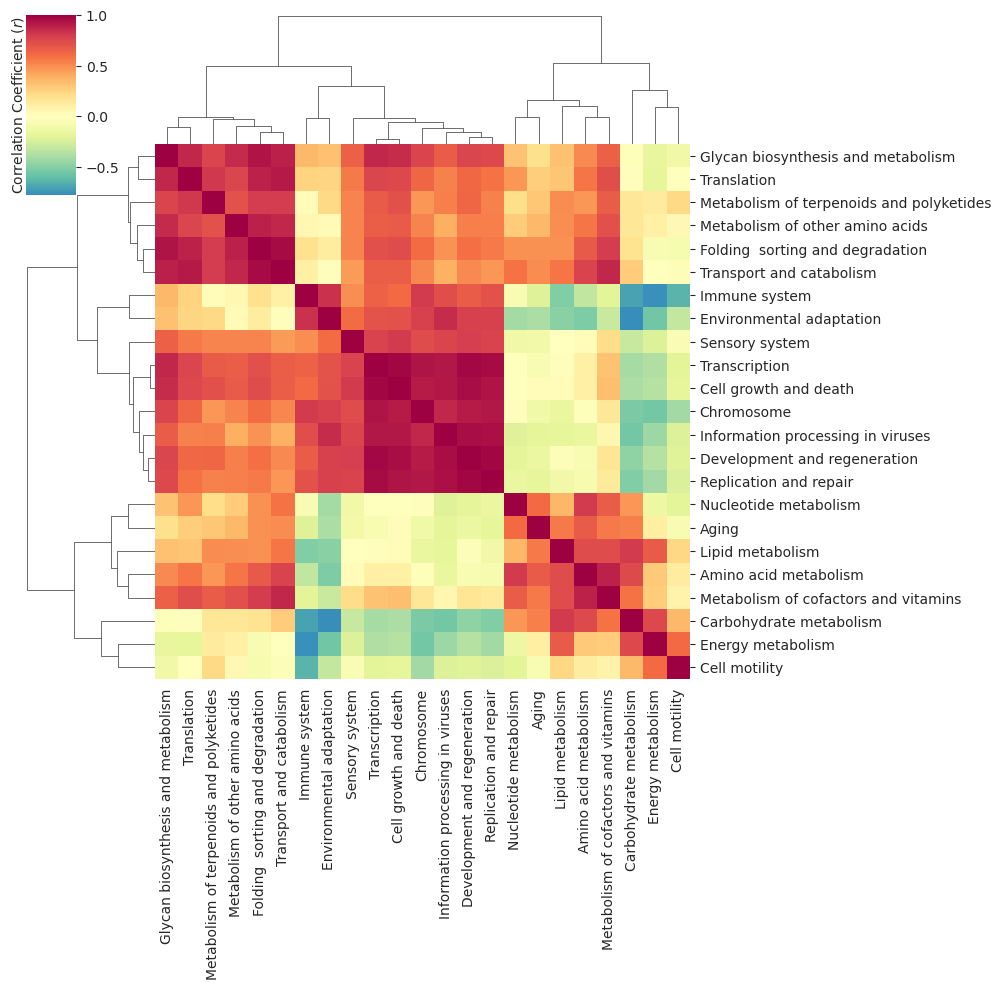

In [41]:
#and now to load said data
functional_correlations = pd.read_csv('data/function_tables/functional_correlations.csv', index_col=0)
functional_correlations.index = functional_correlations.index.str.replace('.', ' ')
functional_correlations.columns = functional_correlations.columns.str.replace('.', ' ')

#and now for a heatmap + heirachical clustering
cluster = sns.clustermap(functional_correlations, figsize=(10, 10), cmap="Spectral_r", center=0, cbar_kws={'label': "Pearson's $r$"})

cbar = cluster.ax_heatmap.collections[0].colorbar
cbar.set_label("Correlation Coefficient ($r$)", labelpad=0)
cbar.ax.yaxis.set_label_position('left')

plt.savefig('../figures/primary/functional_correlations.pdf')

In [49]:
#a quick stat
immune_vs_energy_stats = scipy.stats.pearsonr(immune_expression, energy_metabolism)
immune_vs_carb_stats = scipy.stats.pearsonr(immune_expression, carbohydrate_metabolism)

print(immune_vs_energy_stats)
print(immune_vs_carb_stats)

PearsonRResult(statistic=-0.7641810950984583, pvalue=1.6735478945959803e-10)
PearsonRResult(statistic=-0.7038779137711203, pvalue=1.682036223408903e-08)


# Immunity - metabolism models

In [4]:
#Now I want to fit some models
# the exponential decay function
def exponential_decay(x, a, b, c):
    return a * np.exp(-b * x) + c

#a function to generate predictions and CI
def fit_exponential_decay(data, x_col, y_col):
    x = np.array(list(data[x_col]))
    y = np.array(list(data[y_col]))
    
    params, covariance = curve_fit(exponential_decay, x, y)
    a, b, c = params
    
    # Extract the fitted parameters and their standard errors
    sigma_a, sigma_b, sigma_c = np.sqrt(np.diag(covariance))
    
    # Generate the fitted curve using the parameters
    y_fit = exponential_decay(x, a, b, c)
    
    # Calculate the residuals
    residuals = y - y_fit
    
    x_obs, y_pred = zip(*sorted(zip(x, y_fit)))
    ci = 0.1 * np.std(y_pred) / np.mean(y_pred)
    
    output = {'y_pred' : y_pred, 'residuals' : residuals, 'x_values' : x_obs, 'ci' : ci}
    
    print("\nExponential Decay Model Fit Summary:\n")
    print(f"Fitted Parameters:\n"
      f"a = {a} (SE = {sigma_a})\n"
      f"b = {b} (SE = {sigma_b})\n"
      f"c = {c} (SE = {sigma_c})")

    sum_squared_residuals = np.sum(residuals**2)
    print(f"Sum of squared residuals: {sum_squared_residuals}")
    
    return output

# the exponential decay function
def linear_model(x, m, b):
    return m*x+b

#a function to generate predictions and CI
def fit_linear_model(data, x_col, y_col):
    x = np.array(list(data[x_col]))
    y = np.array(list(data[y_col]))
    
    params, covariance = curve_fit(linear_model, x, y)
    m, b = params
    
    # Extract the fitted parameters and their standard errors
    sigma_m, sigma_b = np.sqrt(np.diag(covariance))
    
    # Generate the fitted curve using the parameters
    y_fit = linear_model(x,m,b)
    
    # Calculate the residuals
    residuals = y - y_fit
    
    x_obs, y_pred = zip(*sorted(zip(x, y_fit)))
    ci = 0.1 * np.std(y_pred) / np.mean(y_pred)
    
    output = {'y_pred' : y_pred, 'residuals' : residuals, 'x_values' : x_obs, 'ci' : ci}
    
    print("\nLinear Model Fit Summary:\n")
    print(f"Fitted Parameters:\n"
      f"m = {m} (SE = {sigma_m})\n"
      f"b = {b} (SE = {sigma_b})\n")

    sum_squared_residuals = np.sum(residuals**2)
    print(f"Sum of squared residuals: {sum_squared_residuals}")
    
    return output

In [5]:
#it looks like energy metabolism and immunity are pretty heavily negatively correlated
#I'll try to plot these directly

samples = list(organismal_df.index)
immunity_metabolism_data = pd.DataFrame(index=samples)

plant = list(organismal_df["plant"])
stage = list(organismal_df["developmental_stage"])
immune_expression = list(organismal_df["Immune system"])
energy_metabolism = list(metabolism_df["Energy metabolism"])
carbohydrate_metabolism = list(metabolism_df["Carbohydrate metabolism"])
cell_motility = list(cellular_df["Cell motility"])

immunity_metabolism_data['Immunity'] = immune_expression
immunity_metabolism_data['Energy_metabolism'] = energy_metabolism
immunity_metabolism_data['Carbohydrate_metabolism'] = carbohydrate_metabolism
immunity_metabolism_data['Cell_motility'] = cell_motility

immunity_metabolism_data['stage']= stage
immunity_metabolism_data['plant']= plant

#divide by 10K for model fitting
immunity_metabolism_data['Immunity'] = immunity_metabolism_data['Immunity'] / 10000
immunity_metabolism_data['Energy_metabolism'] = immunity_metabolism_data['Energy_metabolism'] / 10000
immunity_metabolism_data['Carbohydrate_metabolism'] = immunity_metabolism_data['Carbohydrate_metabolism'] / 10000
immunity_metabolism_data['Cell_motility'] = immunity_metabolism_data['Cell_motility'] / 10000

#separate inc and cur
immunity_metabolism_data_cur = immunity_metabolism_data.loc[immunity_metabolism_data['plant'] == 'A. curassavica']
immunity_metabolism_data_inc = immunity_metabolism_data.loc[immunity_metabolism_data['plant'] == 'A. incarnata']

In [6]:
#immunty vs energy metabolism model
print("Immunity vs Energy Metabolism Models")
immunity_vs_energy_exp_decay_model = fit_exponential_decay(data = immunity_metabolism_data, 
                                                x_col = 'Energy_metabolism', 
                                                y_col = 'Immunity')

immunity_vs_energy_linear_model = fit_linear_model(data = immunity_metabolism_data, 
                                                x_col = 'Energy_metabolism', 
                                                y_col = 'Immunity')

print("\n\n\nImmunity vs Carbohydrate Metabolism Models")

#immunty vs carbohydrate metabolism model
immunity_vs_carb_exp_decay_model = fit_exponential_decay(data = immunity_metabolism_data, 
                                                x_col = 'Carbohydrate_metabolism', 
                                                y_col = 'Immunity')

immunity_vs_carb_linear_model = fit_linear_model(data = immunity_metabolism_data, 
                                                x_col = 'Carbohydrate_metabolism', 
                                                y_col = 'Immunity')

Immunity vs Energy Metabolism Models

Exponential Decay Model Fit Summary:

Fitted Parameters:
a = 0.4631863209300618 (SE = 0.05364863040588776)
b = 0.5300443540812815 (SE = 0.13886141312097453)
c = 0.14799348406799223 (SE = 0.01963557208710015)
Sum of squared residuals: 0.12854736902333547

Linear Model Fit Summary:

Fitted Parameters:
m = -0.03400753750918304 (SE = 0.004186883344000011)
b = 0.38839164793450925 (SE = 0.022515421652200912)

Sum of squared residuals: 0.24334703017206152



Immunity vs Carbohydrate Metabolism Models

Exponential Decay Model Fit Summary:

Fitted Parameters:
a = 1.3869548624751986 (SE = 0.6888323475120687)
b = 4.326950902336774 (SE = 1.313681070182644)
c = 0.16622408202341354 (SE = 0.016183969750088692)
Sum of squared residuals: 0.19056602933384229

Linear Model Fit Summary:

Fitted Parameters:
m = -0.20374277132695792 (SE = 0.029990974378510404)
b = 0.4316220677204893 (SE = 0.032358845028679)

Sum of squared residuals: 0.2951301252843784


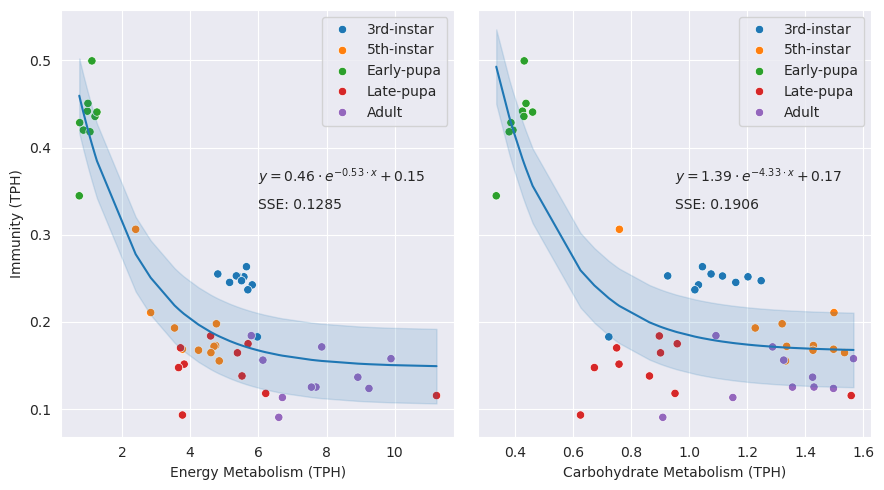

In [36]:
sns.set_style('darkgrid')
sns.set_palette("tab10")
fig, [ax1, ax2] = plt.subplots(1, 2, figsize=(9, 5), sharey=True)

#plot immunity vs energy metabolism
sns.scatterplot(data=immunity_metabolism_data, y="Immunity", x="Energy_metabolism", hue="stage", ax=ax1)
sns.lineplot(x=immunity_vs_energy_exp_decay_model['x_values'], 
             y=immunity_vs_energy_exp_decay_model['y_pred'], ax=ax1)
ax1.fill_between(immunity_vs_energy_exp_decay_model['x_values'], 
                 (immunity_vs_energy_exp_decay_model['y_pred']-immunity_vs_energy_exp_decay_model['ci']), 
                 (immunity_vs_energy_exp_decay_model['y_pred']+immunity_vs_energy_exp_decay_model['ci']), 
                 color='tab:blue', alpha=0.15)
ax1.set_xlabel('Energy Metabolism (TPH)')
ax1.set_ylabel('Immunity (TPH)')
ax1.text(6, 0.36, r'$y = 0.46 \cdot e^{-0.53 \cdot x} + 0.15$')
ax1.text(6, 0.33, 'SSE: 0.1285')

#plot immunity vs carbohydrate metabolism
sns.scatterplot(data=immunity_metabolism_data, y="Immunity", x="Carbohydrate_metabolism", hue="stage", ax=ax2)
sns.lineplot(x=immunity_vs_carb_exp_decay_model['x_values'], 
             y=immunity_vs_carb_exp_decay_model['y_pred'], ax=ax2)
ax2.fill_between(immunity_vs_carb_exp_decay_model['x_values'], 
                 (immunity_vs_carb_exp_decay_model['y_pred']-immunity_vs_energy_exp_decay_model['ci']), 
                 (immunity_vs_carb_exp_decay_model['y_pred']+immunity_vs_energy_exp_decay_model['ci']), 
                 color='tab:blue', alpha=0.15)
ax2.set_xlabel('Carbohydrate Metabolism (TPH)')
ax2.set_ylabel('')
ax2.text(0.95, 0.36, r'$y = 1.39 \cdot e^{-4.33 \cdot x} + 0.17$')
ax2.text(0.95, 0.33, 'SSE: 0.1906')

plt.tight_layout()
plt.savefig('../figures/primary/immunnity_metabolism_models.pdf')

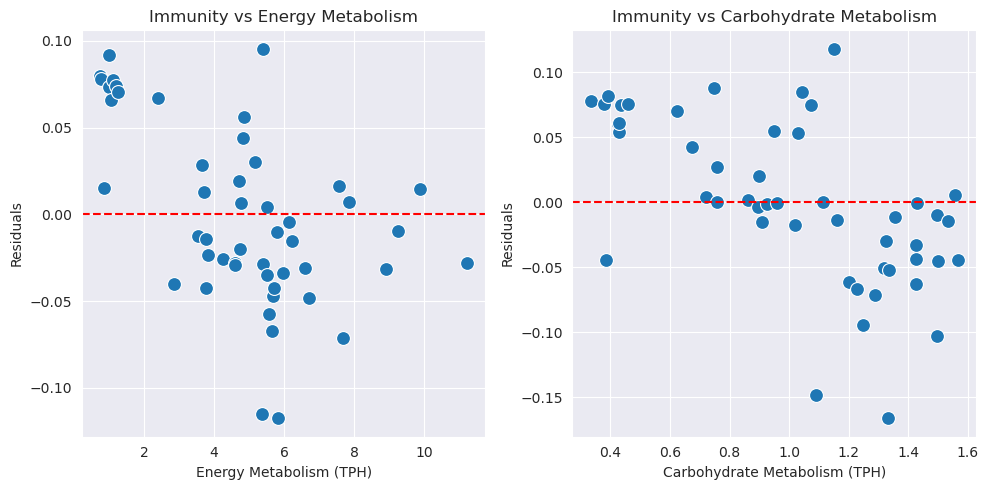

In [51]:
#and we'll plot the residuals
fig, [ax1, ax2] = plt.subplots(1, 2, figsize=(10, 5))

sns.scatterplot(y=immunity_vs_energy_exp_decay_model['residuals'], 
                x=immunity_vs_energy_exp_decay_model['x_values'], ax=ax1, s=100)
ax1.axhline(0, color='red', linestyle='--')
ax1.set_title('Immunity vs Energy Metabolism')
ax1.set_xlabel('Energy Metabolism (TPH)')
ax1.set_ylabel('Residuals')

sns.scatterplot(y=immunity_vs_carb_exp_decay_model['residuals'], 
                x=immunity_vs_carb_exp_decay_model['x_values'], ax=ax2, s=100)
ax2.axhline(0, color='red', linestyle='--')
ax2.set_title('Immunity vs Carbohydrate Metabolism')
ax2.set_xlabel('Carbohydrate Metabolism (TPH)')
ax2.set_ylabel('Residuals')

plt.tight_layout()
plt.savefig('../figures/supplemental/immunity_metabolism_models_residual_plots.pdf')

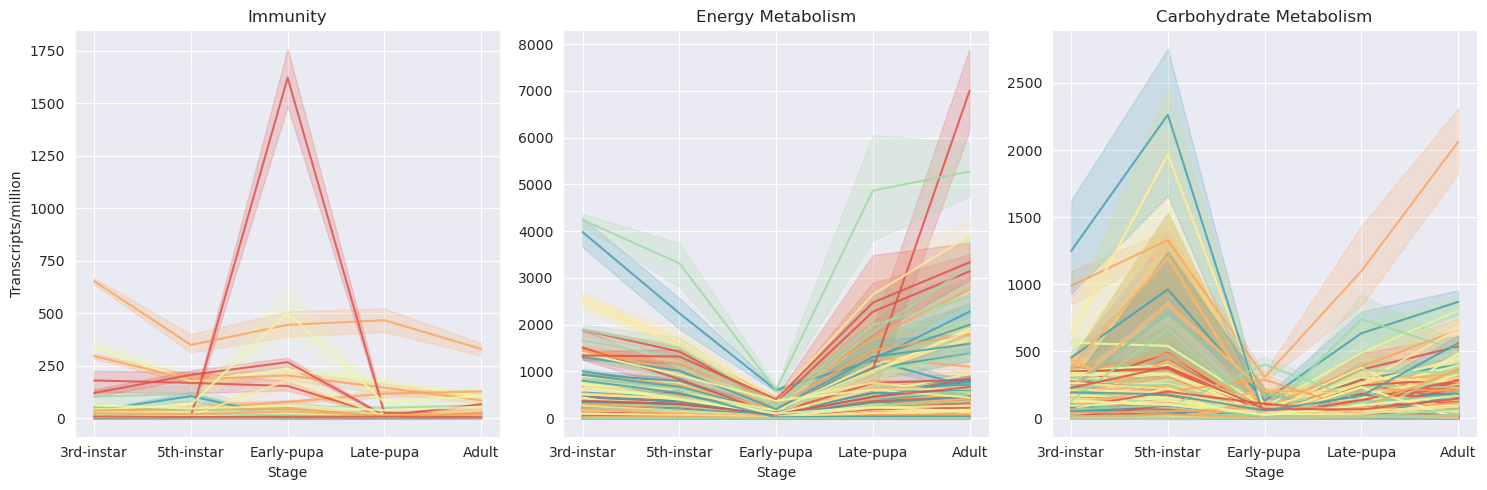

In [33]:
sns.set_palette("Spectral_r")
#and now to plot the actual expression of metabolism genes (that are implied in multiple types of metabolism)
fig, [ax1,ax2,ax3] = plt.subplots(1, 3, figsize=(15, 5))

#plot metabolism genes
for gene_id in multi_metabolism_genes:
    protein_id = gene_id.split('_')[2]
    gbid = protein_to_gene_dict[protein_id]
    
    #get function
    if gbid in dpl_kegg_dict:
        functions = dpl_kegg_dict[gbid]
        
        metabolism_groups = []
        for function in functions:
            functional_heirarchy = function['functional_heirarcy']
            level1 = functional_heirarchy['functional_group_level1']
            if level1 == 'Metabolism':
                level2 = functional_heirarchy['functional_group_level2']
                if level2 not in metabolism_groups:
                    metabolism_groups.append(level2)
            
        #add to explicit dataframe
        if len(metabolism_groups) >= 1:
            for subclass in metabolism_groups:
                metabolism_class = subclass
                if metabolism_class == 'Carbohydrate metabolism':
                    sns.lineplot(data = sorted_df, x='developmental_stage', y=gene_id, ax=ax3, alpha=0.85)
                elif metabolism_class == 'Energy metabolism':
                    sns.lineplot(data = sorted_df, x='developmental_stage', y=gene_id, ax=ax2, alpha=0.85)

#plot immunity genes
for gene_id in organismal_genes:
    protein_id = gene_id.split('_')[2]
    gbid = protein_to_gene_dict[protein_id]
    
    #get function
    if gbid in dpl_kegg_dict:
        functions = dpl_kegg_dict[gbid]
        
        organismal_groups = []
        for function in functions:
            functional_heirarchy = function['functional_heirarcy']
            level1 = functional_heirarchy['functional_group_level1']
            if level1 == 'Organismal Systems':
                level2 = functional_heirarchy['functional_group_level2']
                if level2 not in organismal_groups:
                    organismal_groups.append(level2)
            
        organismal_class = organismal_groups[0]
        if organismal_class == 'Immune system':
            sns.lineplot(data = sorted_df, x='developmental_stage', y=gene_id, ax=ax1, alpha=0.85)

ax1.set_ylabel('Transcripts/million')
ax1.set_xlabel('Stage')
ax2.set_ylabel('')
ax2.set_xlabel('Stage')
ax3.set_ylabel('')
ax3.set_xlabel('Stage')

ax1.set_title('Immunity')
ax2.set_title('Energy Metabolism')
ax3.set_title('Carbohydrate Metabolism')

plt.tight_layout()

plt.savefig('../figures/primary/immunity_metabolism_expression_profiles.pdf')

# High Correlation Clusters

In [54]:
#there seems to be a big chunk of things that are positively correlated. I'll look at these

#Transcription
#Cell growth and death
#Chromosome
#Information processing in viruses
#Development and regeneration
#Replication and repair

#it looks like energy metabolism and immunity are pretty heavily negatively correlated
#I'll try to plot these directly

samples = list(organismal_df.index)
high_cor_data = pd.DataFrame(index=samples)

plant = list(organismal_df["plant"])
stage = list(organismal_df["developmental_stage"])

transcription = list(genetic_df["Transcription"])
cell_growth_death = list(cellular_df["Cell growth and death"])
chromosome = list(genetic_df["Chromosome"])
development = list(organismal_df["Development and regeneration"])
replication_and_repair = list(genetic_df["Replication and repair"])

high_cor_data['Transcription'] = transcription
high_cor_data['Cell_growth_death'] = cell_growth_death
high_cor_data['Chromosome'] = chromosome
high_cor_data['Development'] = development
high_cor_data['Replication_repair'] = replication_and_repair

high_cor_data['stage']= stage
high_cor_data['plant']= plant

#divide by 10K for model fitting

high_cor_data['Transcription'] = high_cor_data['Transcription'] / 10000
high_cor_data['Cell_growth_death'] = high_cor_data['Cell_growth_death'] / 10000
high_cor_data['Chromosome'] = high_cor_data['Chromosome'] / 10000
high_cor_data['Development'] = high_cor_data['Development'] / 10000
high_cor_data['Replication_repair'] = high_cor_data['Replication_repair'] / 10000

In [61]:
#immunty vs energy metabolism model
print("Dorso-ventral axis formation vs Transcription")
dva_vs_transcription_linear_model = fit_linear_model(data = high_cor_data, 
                                                x_col = 'Transcription', 
                                                y_col = 'Development')

print("\n\nDorso-ventral axis formation vs Apoptosis")
dva_vs_transcription_linear_model = fit_linear_model(data = high_cor_data, 
                                                x_col = 'Cell_growth_death', 
                                                y_col = 'Development')

print("\n\nDorso-ventral axis formation vs Epigenetic Remodeling")
dva_vs_transcription_linear_model = fit_linear_model(data = high_cor_data, 
                                                x_col = 'Chromosome', 
                                                y_col = 'Development')

print("\n\nDorso-ventral axis formation vs DNA Replication and Repair")
dva_vs_transcription_linear_model = fit_linear_model(data = high_cor_data, 
                                                x_col = 'Replication_repair', 
                                                y_col = 'Development')

Dorso-ventral axis formation vs Transcription

Linear Model Fit Summary:

Fitted Parameters:
m = 0.18505211238813962 (SE = 0.007022303186890528)
b = 0.004462582472540532 (SE = 0.0025026993645118865)

Sum of squared residuals: 0.0023913816360891854


Dorso-ventral axis formation vs Apoptosis

Linear Model Fit Summary:

Fitted Parameters:
m = 0.7383195529276577 (SE = 0.03395078010399708)
b = -0.02080234912554718 (SE = 0.004115711370760873)

Sum of squared residuals: 0.0034102133264384024


Dorso-ventral axis formation vs Epigenetic Remodeling

Linear Model Fit Summary:

Fitted Parameters:
m = 0.14008494381996883 (SE = 0.009471756146210023)
b = 0.014497410889362801 (SE = 0.00379723782651941)

Sum of squared residuals: 0.006672179968372279


Dorso-ventral axis formation vs DNA Replication and Repair

Linear Model Fit Summary:

Fitted Parameters:
m = 1.144682246512947 (SE = 0.039411275974416855)
b = 0.003908450041996724 (SE = 0.002290249590202283)

Sum of squared residuals: 0.00199087567610

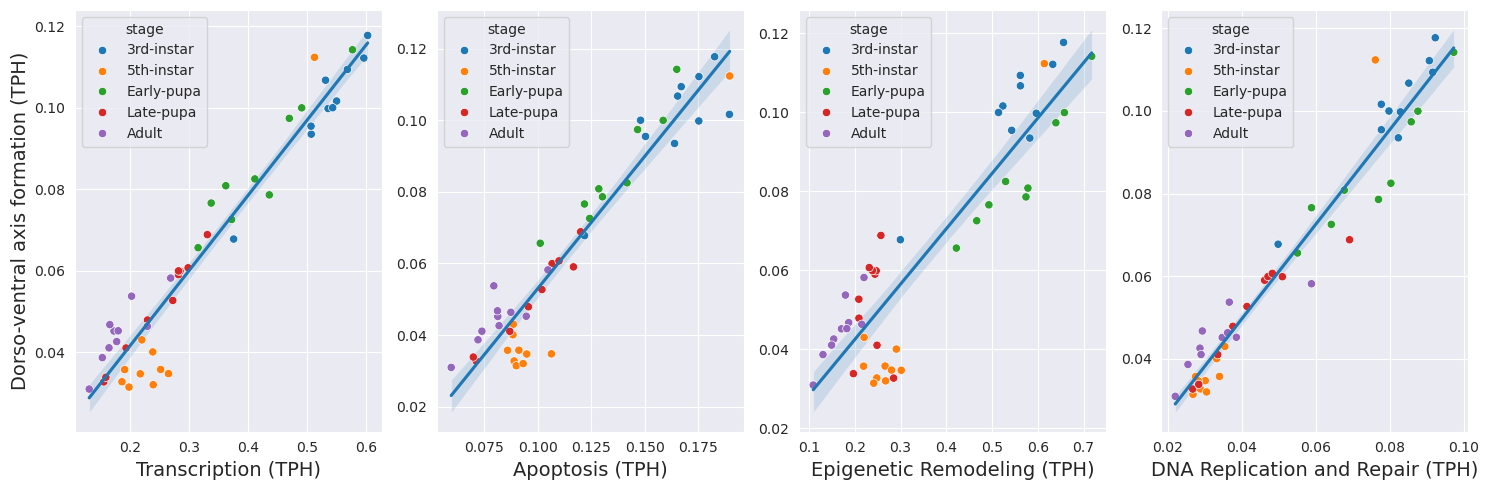

In [71]:
fig, [ax1, ax2, ax3, ax4] = plt.subplots(1, 4, figsize=(15, 5))
sns.set_style('darkgrid')

sns.regplot(data=high_cor_data, y="Development", x="Transcription", scatter=False, ax=ax1)
sns.scatterplot(data=high_cor_data, y="Development", x="Transcription", hue="stage", ax=ax1)
ax1.set_ylabel('Dorso-ventral axis formation (TPH)', size=14)
ax1.set_xlabel('Transcription (TPH)', size=14)

sns.regplot(data=high_cor_data, y="Development", x="Cell_growth_death", scatter=False, ax=ax2)
sns.scatterplot(data=high_cor_data, y="Development", x="Cell_growth_death", hue="stage", ax=ax2)
ax2.set_ylabel('')
ax2.set_xlabel('Apoptosis (TPH)', size=14)


sns.regplot(data=high_cor_data, y="Development", x="Chromosome", scatter=False, ax=ax3)
sns.scatterplot(data=high_cor_data, y="Development", x="Chromosome", hue="stage", ax=ax3)
ax3.set_ylabel('')
ax3.set_xlabel('Epigenetic Remodeling (TPH)', size=14)

sns.regplot(data=high_cor_data, y="Development", x="Replication_repair", scatter=False, ax=ax4)
sns.scatterplot(data=high_cor_data, y="Development", x="Replication_repair", hue="stage", ax=ax4)
ax4.set_ylabel('')
ax4.set_xlabel('DNA Replication and Repair (TPH)', size=14)

plt.tight_layout()

plt.savefig('../figures/primary/developmental_correlations.pdf')